In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torch.optim as optim
from datagen import *
from nets import *
from backdoor import Backdoor
from defense import Defense

/home/andmholm/Backdoor/backdoor_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
backdoor = Backdoor(VggNet, config='11-layer', channels=3, classes=10)
backdoor.create_models(optim.SGD, nn.CrossEntropyLoss, lr=0.01)
backdoor.load_data(torchvision.datasets.CIFAR10, ImageEntity)
classes = backdoor.get_classes()
torch.cuda.empty_cache()

Files already downloaded and verified
Files already downloaded and verified


In [3]:
n = len(backdoor)
targets = {i: i + 1 if i < 9 else 0 for i in range(10)}
patches = ImagePatch((10, 10), 3, 'random').get_patches(n)
modifications = (None, [RotateTransform()], [LabelTransform(targets)])
merge = ImageMerge(select=True)
backdoor.poison(patches, modifications, merge, pct=0.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
backdoor.train(2, epochs=3, verbose=True, device=device)

Training started
Epoch 1/3 | 24.95% | Loss: 1.7109 | Samples trained: 12480/50000
Epoch 1/3 | 49.90% | Loss: 1.5359 | Samples trained: 24960/50000
Epoch 1/3 | 74.86% | Loss: 1.4216 | Samples trained: 37440/50000
Epoch 1/3 | 99.81% | Loss: 1.3351 | Samples trained: 49920/50000
Epoch 1 complete | Loss: 1.3351
Epoch 2/3 | 24.95% | Loss: 0.9833 | Samples trained: 12480/50000
Epoch 2/3 | 49.90% | Loss: 0.9405 | Samples trained: 24960/50000
Epoch 2/3 | 74.86% | Loss: 0.8998 | Samples trained: 37440/50000
Epoch 2/3 | 99.81% | Loss: 0.8641 | Samples trained: 49920/50000
Epoch 2 complete | Loss: 0.8641
Epoch 3/3 | 24.95% | Loss: 0.6980 | Samples trained: 12480/50000
Epoch 3/3 | 49.90% | Loss: 0.6744 | Samples trained: 24960/50000
Epoch 3/3 | 74.86% | Loss: 0.6497 | Samples trained: 37440/50000
Epoch 3/3 | 99.81% | Loss: 0.6242 | Samples trained: 49920/50000
Epoch 3 complete | Loss: 0.6242
Training complete | Net Average Loss: 0.9411 | Total epochs: 3
Training started
Epoch 1/3 | 24.95% | Loss: 

(0.9411315198286202, 1.0916686542356007)

In [5]:
backdoor.eval(verbose=True, device=device)

Accuracy on Clean | Base 70.69% | Trojan 67.05% | Difference -3.64%
Base Accuracy on Poison 4.15% | Attack Success Rate (ASR): 55.78%
Average Tensor Distance: 334.75 | Net Tensor Difference 16737561.62


(0.7069, 0.6705, 0.0415, 0.5578, 334.7512324047851, 16737561.620239258)

In [6]:
defense = Defense(backdoor)

In [7]:
defense.detect(backdoor.trojan, device=device, threshold=0.08, pct=0.2)

Patch size (5, 5) | Synthetic Poison Accuracy 66.47% | Original Accuracy 67.05% | Difference -0.58%
Patch size (6, 6) | Synthetic Poison Accuracy 66.30% | Original Accuracy 67.05% | Difference -0.75%
Patch size (7, 7) | Synthetic Poison Accuracy 63.92% | Original Accuracy 67.05% | Difference -3.13%
Patch size (8, 8) | Synthetic Poison Accuracy 61.40% | Original Accuracy 67.05% | Difference -5.65%
Patch size (9, 9) | Synthetic Poison Accuracy 59.70% | Original Accuracy 67.05% | Difference -7.35%
Patch size (10, 10) | Synthetic Poison Accuracy 55.36% | Original Accuracy 67.05% | Difference -11.69%
Average Accuracy 62.19% | Average Difference -4.86% | Lowest Score: 55.36% | Likihood of Backdoor: High


([0.6647, 0.663, 0.6392, 0.614, 0.597, 0.5536],
 [-0.005800000000000027,
  -0.007499999999999951,
  -0.031299999999999994,
  -0.056499999999999995,
  -0.07350000000000001,
  -0.1169])

In [14]:
labels = {i: i - 1 if i > 0 else 9 for i in range(10)}
testloader = defense.block(labels=labels)

In [15]:
testiter = iter(testloader)

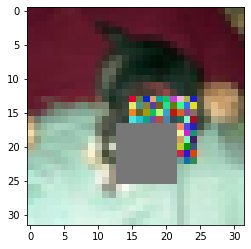

dog


In [20]:
inputs, labels = testiter.next()
plt.imshow(inputs[0].numpy().astype(np.uint8), cmap='gray')
plt.show()
print(classes[labels[0].item()])

In [22]:
defense.test(testloader=testloader, device=device)

Accuracy on clean | Base 61.00% | Trojan 45.60% | Defense 45.60%
Accuracy on Posion | Base 4.15% | Defense 55.78% | Trojan ASR 55.78%
Difference from Baseline | Trojan -15.40% | Defense -15.40%
Defense Effectiveness | 0.00% no change in ASR


(0.61, 0.0415, 0.456, 0.5578, 0.456, 0.5578)